<a href="https://colab.research.google.com/github/kazuki-komori/JR-ngram-similarity/blob/master/JR_ngram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup

In [2]:
!pip install openpyxl
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
# !pip install mecab-python3
!pip install janome
!pip install japanize-matplotlib
!pip install -U ginza
# ginza setup
import pkg_resources, imp
imp.reload(pkg_resources)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
git is already installed at the requested version (1:2.17.1-1ubuntu0.8)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.13)
xz-utils is already installed at the requested version (5.2.2-1.3)
The following NEW packages will be installed:
  file libmagic-mgc{a} libmagic1{a} libmecab-dev libmecab2{a} mecab mecab-ipadic{a} mecab-ipadic-utf8 mecab-jumandic{a} mecab-jumandic-utf8{a} mecab-utils{a} 
0 packages upgraded

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

#### テキストの読み込み


In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [4]:
import pandas as pd

data = pd.read_excel("data.xlsx", index_col = None)

In [5]:
bf_positive = data[data["朝食_ポジティブ"] == 1]
bf_negative = data[data["朝食_ネガティブ"] == 1]
di_positive = data[data["夕食_ポジティブ"] == 1]
di_negative = data[data["夕食_ネガティブ"] == 1]
ba_positive = data[data["風呂_ポジティブ"] == 1]
ba_negative = data[data["風呂_ネガティブ"] == 1]
se_positive = data[data["サービス_ポジティブ"] == 1]
se_negative = data[data["サービス_ネガティブ"] == 1]
pl_positive = data[data["立地_ポジティブ"] == 1]
pl_negative = data[data["立地_ネガティブ"] == 1]
am_positive = data[data["設備・アメニティ_ポジティブ"] == 1]
am_negative = data[data["設備・アメニティ_ネガティブ"] == 1]
ro_positive = data[data["部屋_ポジティブ"] == 1]
ro_negative = data[data["部屋_ネガティブ"] == 1]


In [6]:
## データを取り出す
bf_positive_txt = "".join(bf_positive["レビュー文"].values.tolist())
bf_negative_txt = "".join(bf_negative["レビュー文"].values.tolist())
di_positive_txt = "".join(di_positive["レビュー文"].values.tolist())
di_negative_txt = "".join(di_negative["レビュー文"].values.tolist())
ba_positive_txt = "".join(ba_positive["レビュー文"].values.tolist())
ba_negative_txt = "".join(ba_negative["レビュー文"].values.tolist())
se_positive_txt = "".join(se_positive["レビュー文"].values.tolist())
se_negative_txt = "".join(se_negative["レビュー文"].values.tolist())
pl_positive_txt = "".join(pl_positive["レビュー文"].values.tolist())
pl_negative_txt = "".join(pl_negative["レビュー文"].values.tolist())
am_positive_txt = "".join(am_positive["レビュー文"].values.tolist())
am_negative_txt = "".join(am_negative["レビュー文"].values.tolist())
ro_positive_txt = "".join(ro_positive["レビュー文"].values.tolist())
ro_negative_txt = "".join(ro_negative["レビュー文"].values.tolist())

In [7]:
# テキストデータを辞書型で作成
data_dic = {}
data_dic["bf"] = [bf_positive_txt, bf_negative_txt]
data_dic["di"] = [di_positive_txt, di_negative_txt]
data_dic["ba"] = [ba_positive_txt, ba_negative_txt]
data_dic["se"] = [se_positive_txt, se_negative_txt]
data_dic["pl"] = [pl_positive_txt, pl_negative_txt]
data_dic["am"] = [am_positive_txt, am_negative_txt]
data_dic["ro"] = [ro_positive_txt, ro_negative_txt]

In [ ]:
f = open("/content/drive/MyDrive/JR/dbf_positive.txt", "a", encoding="UTF-8")
f.write("".join(bf_positive_list))
f.close()

18243

In [8]:
from janome.tokenizer import Tokenizer

def split_into_words(doc):
    """
    名詞だけを取り出してリストで戻す関数
    """
    try:
        t = Tokenizer(mmap=True)
        word_list = []
        # 形態素して取り出す
        for token in t.tokenize(doc):
            # 品詞の判定をして、名詞か動詞か形容詞だけを取り出す
            if (token.part_of_speech.split(",")[0] in ("名詞","動詞","形容詞")
                and  token.part_of_speech.split(",")[1] != "数"):  # ただし、数詞は使っても意味が薄いので捨てる
                # 表層形を登録する
                word_list.append(token.surface)
        return word_list
    except Exception as ex:
        print(ex)
        return []

In [37]:
import spacy

def ginza_split(doc):
  """
  ginzaで形態素解析がしたい
  """
  nlp = spacy.load("ja_ginza")
  nlp_doc = nlp(doc)
  word_list = []
  for sent in nlp_doc.sents:
    for token in sent:
      if (token.tag_.split("-")[0] in ("名詞","動詞","形容詞") and  token.tag_.split("-")[1] != "数詞"):
        word_list.append(token.lemma_)
  return word_list

In [51]:
# スコア算出
def scorer(p_dic, n_dic):
  """
  スコアとスコアの影響を与えている内容を返す
  """
  counter = 0
  score_dic = {}
  for p in p_dic:
    for n in n_dic:
      if p == n:
        counter += 1
        if p in score_dic.keys():
          score_dic[p] += 1
        else:
          score_dic[p] = 1
  score_dic_sorted = sorted(score_dic.items(), key=lambda x:x[1], reverse=True)
  return counter / (len(p_dic) + len(n_dic)), score_dic_sorted

In [54]:
import numpy as np
scores = []
idxs = np.array(["朝食", "夕食", "風呂", "サービス", "立地", "設備・アメニティ", "部屋"])
idx = 0
score_dic_sim = {}
for key, d in data_dic.items():
  print("------------------", idxs[idx], "----------------")
  p_dic = ginza_split(d[0])
  n_dic = ginza_split(d[1])
  score, score_dic = scorer(p_dic, n_dic)
  score_dic_sim[idxs[idx]] = score_dic
  scores.append(score)
  idx += 1
  print(score)
  for i in range(7):
    print(score_dic[i])



------------------ 朝食 ----------------
7.333654216403542
('朝食', 9932)
('する', 8250)
('ある', 2849)
('食事', 2820)
('いる', 2205)
('美味しい', 2132)
('思う', 1056)
('良い', 800)
('食べる', 686)
('料理', 672)
------------------ 夕食 ----------------
5.059777347531462
('する', 6026)
('食事', 3640)
('美味しい', 1596)
('ある', 1539)
('いる', 989)
('料理', 768)
('食べる', 738)
('思う', 735)
('良い', 549)
('夕食', 494)
------------------ 風呂 ----------------
4.4717679728478865
('する', 3150)
('風呂', 2400)
('ある', 1495)
('温泉', 828)
('露天風呂', 760)
('いる', 756)
('大浴場', 459)
('良い', 455)
('できる', 430)
('なる', 384)
------------------ サービス ----------------
12.513650640251269
('する', 54036)
('いる', 9240)
('ある', 5871)
('思う', 2784)
('部屋', 2496)
('方', 2294)
('スタッフ', 2163)
('良い', 1802)
('なる', 1683)
('対応', 1602)
------------------ 立地 ----------------
2.4929995757318624
('する', 1320)
('ある', 1292)
('立地', 300)
('思う', 264)
('いる', 264)
('なる', 210)
('駅', 203)
('良い', 188)
('ホテル', 174)
('できる', 132)
------------------ 設備・アメニティ ----------------
8.245203635139683
('する', 1

Mounted at /content/drive


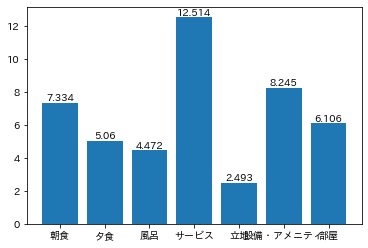

In [40]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt

left = np.array(["朝食", "夕食", "風呂", "サービス", "立地", "設備・アメニティ", "部屋"])
scores_rounded = np.round(scores, decimals=3)
for x, y in zip(left, scores_rounded):
    plt.text(x, y, y, ha='center', va='bottom')
plt.bar(left, scores)
plt.savefig("/content/drive/MyDrive/JR/scores.png")

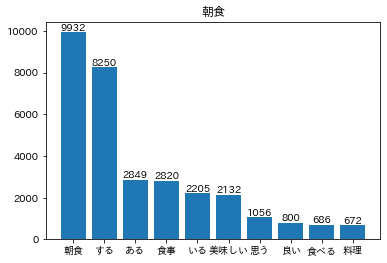

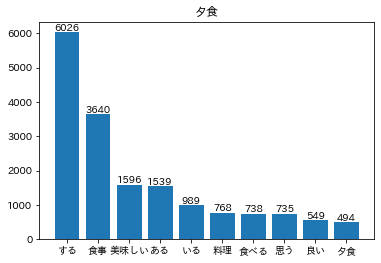

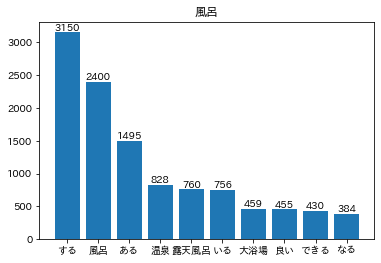

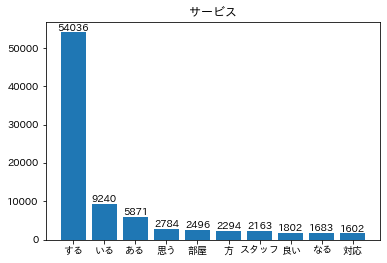

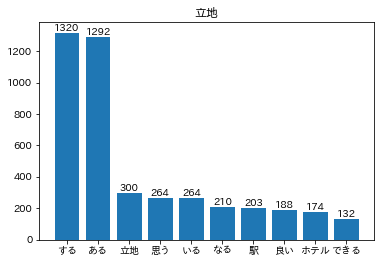

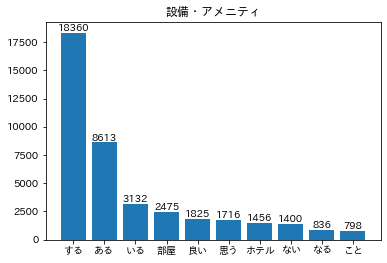

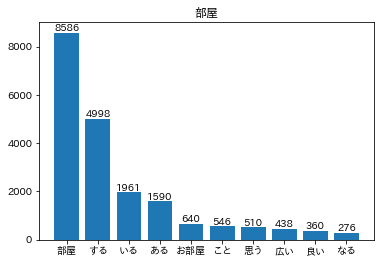

In [71]:
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt

idx = np.array(["朝食", "夕食", "風呂", "サービス", "立地", "設備・アメニティ", "部屋"])
for i in idx:
  plt_scores = []
  plt_tags = []
  for x in score_dic_sim[i][0:10]:
    plt_tags.append(x[0])
    plt_scores.append(x[1])
  for x, y in zip(plt_tags, plt_scores):
    plt.text(x, y, y, ha='center', va='bottom')
  plt.title(i)
  plt.bar(plt_tags, plt_scores)
  plt.show()